In [84]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import scipy
import seaborn as sn
import pandas as pd
import ipywidgets
from datetime import datetime
import glob
from sklearn.linear_model import LinearRegression
#import pymannkendall as mk

ModuleNotFoundError: No module named 'pymannkendall'

In [74]:
def moving_average(timeseries, step):
    return np.convolve(timeseries, np.ones(step), 'valid') / step

In [75]:
import gc

In [29]:
gc.enable()

In [30]:
ROOT = "/data/datasets/Projects/TuringCoccolithophoreBlooms"

In [31]:
filtered_filepath = ROOT+"/AVHRR_reflectance/MASKED_AVHRR/rrs_masked_by_sea_ice.nc"
#filepath = ROOT+"/no_backup/TuringCoccolithophoreBlooms/regridded_data/Rrs_560/*.nc"
varname = "filtered_remote_sensing_reflectance"
#varname = 'Rrs_560'
#print(glob.glob(filepath)[11])
ds = xr.open_dataset(filtered_filepath)
#ds = load_data(filepath)
print(ds)
rrs = ds[varname]

<xarray.Dataset>
Dimensions:                              (longitude: 3600, latitude: 1800,
                                          time: 424)
Coordinates:
  * longitude                            (longitude) float64 -179.9 ... 179.9
  * latitude                             (latitude) float64 -89.95 ... 89.95
  * time                                 (time) datetime64[ns] 1981-09-30 ......
Data variables:
    filtered_remote_sensing_reflectance  (time, latitude, longitude) float64 ...


In [32]:
#Get edges of grid cells (assuming consistent lat, lon grid)
lon = np.array(ds['longitude'])-0.05
lat = np.array(ds['latitude'])-0.025

#Get end of grid
lon = np.append(lon,ds['longitude'][-1])
lat = np.append(lat,ds['latitude'][-1])

#make into grid
x,y = np.meshgrid(lon,lat)

In [33]:
# Radius of Earth
R = 6371*1000

#Empty area for area
A = np.zeros((len(lon)-1,len(lat)-1))

#Cut grids
x_shift1 = x[1:,1:]
y_shift1 = y[1:,1:]

#Calculate area
A = np.pi/180 * R**2 * (np.sin(y[:-1,:-1]*np.pi/180)-np.sin(y_shift1*np.pi/180))*(x[:-1,:-1]-x_shift1)

In [34]:
#Standard deviation
std = np.std(rrs)

In [35]:
#Calculate yearly mean
yearly = rrs.groupby('time.year').mean('time')

In [51]:
std = np.std(yearly)
rrs_time = pd.to_datetime(rrs.time.values)

In [52]:
years = yearly.year.values
areas = np.zeros(len(years))
for i,y in enumerate(years):
    cut = yearly[yearly.year==y]
    
    #Find number of areas in year with rrs higher than standard deviation
    areas[i] = np.nansum(A[np.squeeze(cut.values)>std.values])

In [53]:
(areas[0]-areas[-1])/(1000*1000)

3087143.0559382816

In [77]:
steps = [1,3,5,7,9]

In [89]:
def stats_of_timeseries(dates,timeseries_data):
    reg = LinearRegression().fit(dates, timeseries_data)
    #mk_t = mk.original_test(timeseries_data)
    return reg

Slope =  -53690.39379222531


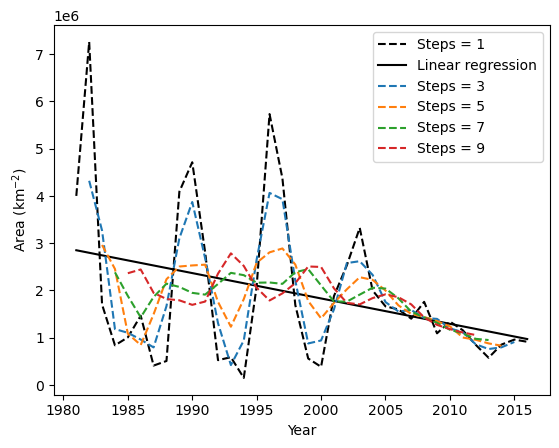

In [101]:
for i,step in enumerate(steps):
    if step==1:
        plt.plot(years,areas/(1000*1000),'k--',label='Steps = {}'.format(step))
        reg = stats_of_timeseries(years.reshape(-1, 1),areas/(1000*1000))
        plt.plot(years,reg.intercept_+reg.coef_[0]*years,'k',label='Linear regression')
        print('Slope = ',reg.coef_[0])
    else:
        plt.plot(moving_average(years,step),moving_average(areas/(1000*1000),step),'--',label='Steps = {}'.format(step))
    plt.legend()
plt.xlabel('Year')
plt.ylabel('Area (km$^{-2}$)')
plt.savefig('area_timeseries.png')

In [102]:
#slices
slice_1 = slice('1981-01-01','1989-12-01')
slice_2 = slice('1990-01-01','1999-12-01')
slice_3 = slice('2000-01-01','2009-12-01')
slice_4 = slice('2010-01-01','2016-12-01')
slices=[slice_1,slice_2,slice_3,slice_4]

In [103]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

In [104]:
colors = [(0, 24/255, 95/255),(0, 154/255, 162/255),(126/255, 201/255, 201/255),(173/255, 255/255, 251/255)]#,(1, 1, 1)]
cmap = LinearSegmentedColormap.from_list('coccolithphores', colors, N=100)

In [105]:
from matplotlib import colors

In [118]:
decade_1 = rrs.sel(time=slice_1)
decade_2 = rrs.sel(time=slice_2)
decade_3 = rrs.sel(time=slice_3)
decade_4 = rrs.sel(time=slice_4)

In [107]:
d1_mean = decade_1.mean(dim='time',skipna=True)
d2_mean = decade_2.mean(dim='time',skipna=True)
d3_mean = decade_3.mean(dim='time',skipna=True)
d4_mean = decade_4.mean(dim='time',skipna=True)
all_mean = rrs.mean(dim='time',skipna=True)

In [119]:
d1_mean = decade_1.mean(dim=['latitude','longitude'],skipna=True)
d2_mean = decade_2.mean(dim=['latitude','longitude'],skipna=True)
d3_mean = decade_3.mean(dim=['latitude','longitude'],skipna=True)
d4_mean = decade_4.mean(dim=['latitude','longitude'],skipna=True)

In [126]:
d_means = [np.array(decade_1).flatten(),np.array(decade_2).flatten(),np.array(decade_3).flatten(),np.array(decade_4).flatten()]

/tmp/ipykernel_300/1540096508.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bp = ax.boxplot(d_means[~np.isnan(d_means)])


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 1000x700 with 0 Axes>

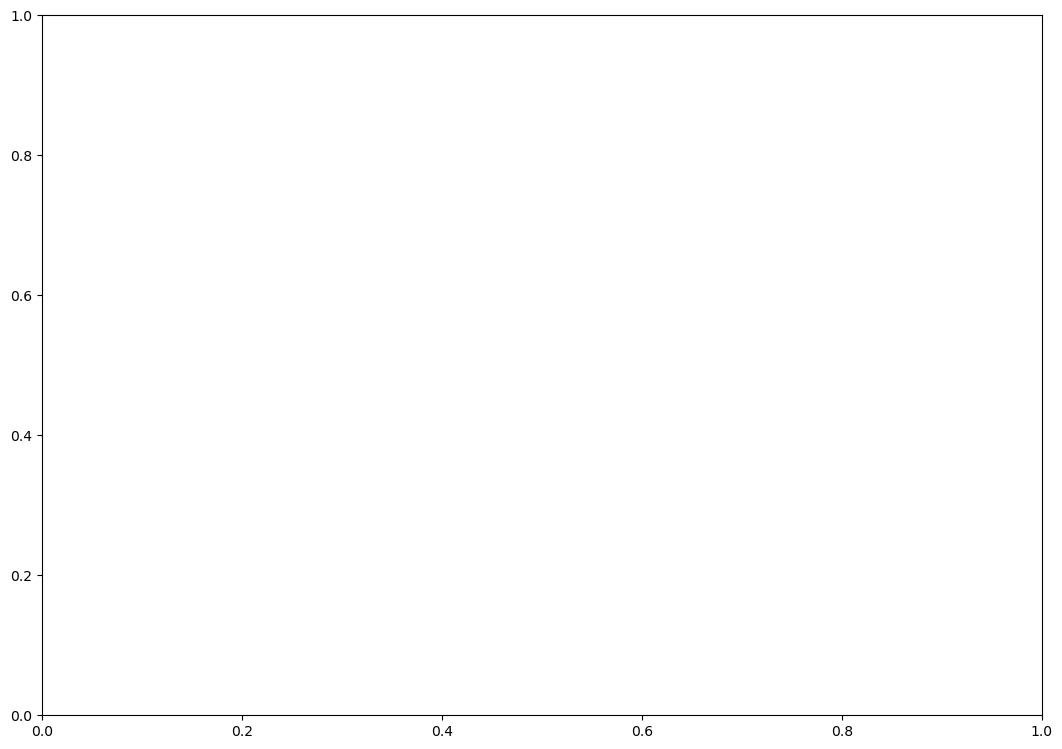

In [128]:
# Define the figure and each axis
fig = plt.figure(figsize =(10, 7))
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(d_means[~np.isnan(d_means)])
 
# show plot
plt.show()

In [65]:
d1 = np.array(d1_mean.values)
d2 = np.array(d2_mean.values)
d3 = np.array(d3_mean.values)
d4 = np.array(d4_mean.values)
all = np.array(all_mean.values)

In [69]:
std = np.nanstd(all)
print(std)

9.496299933331357e-06


In [70]:
d1[d1<std] = np.nan
d2[d2<std] = np.nan
d3[d3<std] = np.nan
d4[d4<std] = np.nan

In [71]:
print('Non nan d1=',np.count_nonzero(~np.isnan(d1)))
print('Non nan d2=',np.count_nonzero(~np.isnan(d2)))
print('Non nan d3=',np.count_nonzero(~np.isnan(d3)))
print('Non nan d4=',np.count_nonzero(~np.isnan(d4)))

Non nan d1= 173183
Non nan d2= 194208
Non nan d3= 170023
Non nan d4= 86841


In [13]:
gc.collect()

73

<xarray.DataArray 'filtered_remote_sensing_reflectance' (latitude: 1800,
                                                         longitude: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * latitude   (latitude) float64 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95


/home/jovyan/lustre_scratch/conda-envs/rapids_env/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/home/jovyan/lustre_scratch/conda-envs/rapids_env/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


<xarray.DataArray 'filtered_remote_sensing_reflectance' (latitude: 1800,
                                                         longitude: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * latitude   (latitude) float64 -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
<xarray.DataArray 'filtered_remote_sensing_reflectance' (latitude: 1800,
                                                         longitude: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ...,

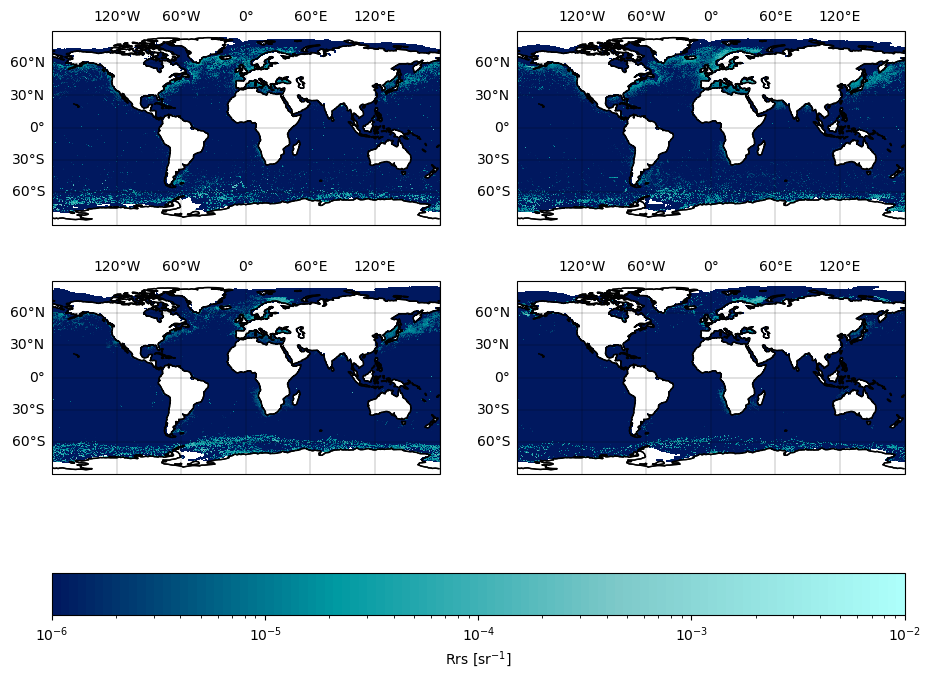

In [14]:
# Define the figure and each axis
fig, axs = plt.subplots(nrows=2,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
axs=axs.flatten()

for i,d_mean in enumerate(d_means):
    print(d_mean)
    im=axs[i].pcolor(d_mean.longitude,d_mean.latitude,d_mean.values,
                          transform = ccrs.PlateCarree(),
                          cmap=cmap,norm=colors.LogNorm(vmin=1e-6, vmax=1e-2))
    axs[i].coastlines()
    cmap.set_bad((0, 24/255, 95/255))
    axs[i].add_feature(cfeat.LAND,color='white')
    axs[i].add_feature(cfeat.COASTLINE)
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.33, color='k',alpha=0.5)
    gl.xlabels_bottom = False
    gl.ylabels_right = False
cbar = plt.colorbar(im,ax=axs.ravel().tolist(),location="bottom")
cbar.set_label('Rrs [sr$^{-1}$]')
#plt.tight_layout()
#plt.show()
plt.savefig('Decadal_trends.png')